### DATA processing

In [94]:
import os 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt

In [46]:
#Assinging the path 
Dataset_dir = "D:/Guvi/Projects/TB Detection/Data/Dataset of Tuberculosis Chest X-rays Images"
Normal_dir = os.path.join(Dataset_dir, "Normal Chest X-rays")
TB_dir = os.path.join(Dataset_dir, "TB Chest X-rays")

img_size = (224, 224)
Batch_size = 32


In [47]:
#check for any corrupt files:
def check_images(path):
    try:
        img =Image.open(path)
        img.verify()
        return True
    except:
        return False

In [48]:
def valid_images_path(folder):
    valid_img = []
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        if check_images(path):
            valid_img.append(path)
    return valid_img

In [49]:
normal_images = valid_images_path(Normal_dir)
TB_images = valid_images_path(TB_dir)

print(f"Valid Normal Images :{len(normal_images)}")
print(f"Valid TB Images :{len(TB_images)}")

Valid Normal Images :514
Valid TB Images :2494


In [50]:
#creating Label & combining the data set :
normal_label = [0]*len(normal_images)
tb_label = [1]*len(TB_images)

images_paths = normal_images+TB_images
labels = normal_label+tb_label

In [52]:
#splitting the data:

from sklearn.model_selection import train_test_split

X_train, X_temp , y_train, y_temp = train_test_split(
    images_paths, 
    labels,
    test_size= 0.30,
    stratify=labels,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

In [53]:
#Loading Data:
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img/255.0
    return img, label

In [54]:
#creating tensors:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

#Preprocessing:
train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = validation_ds.map(load_and_preprocess, num_parallel_calls= tf.data.AUTOTUNE)
test_ds = test_ds.map(load_and_preprocess, num_parallel_calls= tf.data.AUTOTUNE)

#Batch Processing:
train_ds = train_ds.shuffle(1000).batch(Batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(Batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(Batch_size).prefetch(tf.data.AUTOTUNE)

In [58]:
#Data Augmentation:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

In [59]:
def augment (img, label):
    img = data_augmentation(img)
    return img, label
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

### EDA

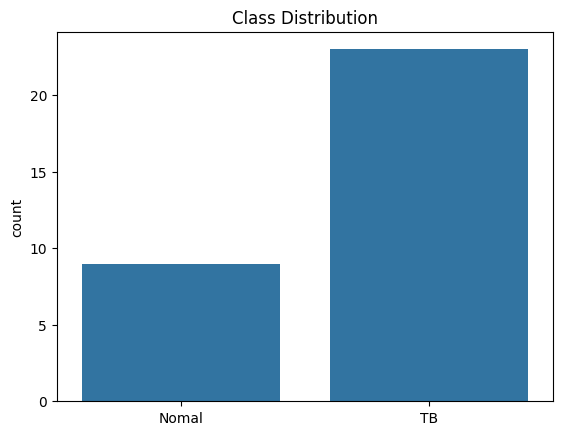

In [75]:
#viz image distribution:

import seaborn as sns
sns.countplot(x=labels)
plt.xticks([0,1], ["Nomal","TB"])
plt.title("Class Distribution")
plt.show()

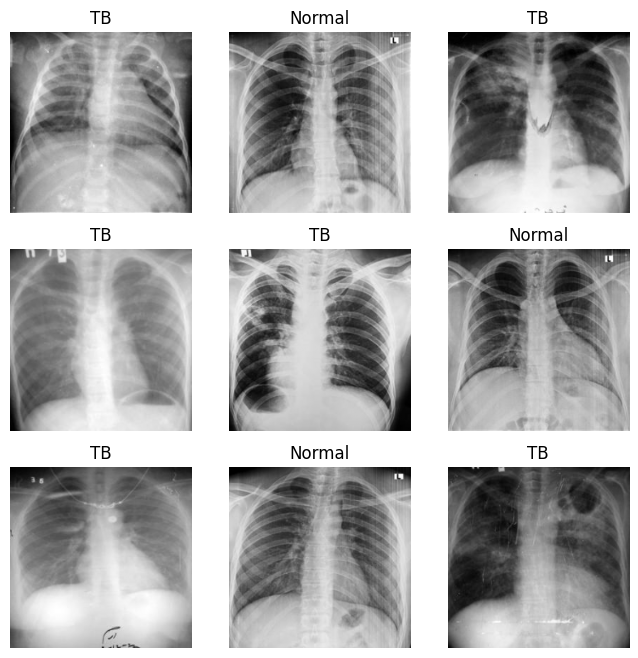

In [ ]:
#class Balance:
#taking data without augmentation
viz_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
viz_ds = viz_ds.map(load_and_preprocess). batch(32)


for images, labels in viz_ds.take(1):
    plt.figure(figsize=(8,8))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i][:,:,0], cmap='gray')
        plt.title("TB" if labels[i]==1 else 'Normal')
        plt.axis('off')
    plt.show()

In [ ]:
#pixel intesity check:
def collect_pixels_by_class(X,y, n_images=100):
    tb_pixels = []
    nor_pixels=[]

    y=np.array(y).reshape(-1)

    tb_idx = np.where(y==1)[0][:n_images]
    nor_idx = np.where(y==0)[0][:n_images]

    for idx in tb_idx:
        img, _ = load_and_preprocess(X[idx], 1)
        tb_pixels.append(tf.reshape(img[:,:,0],[-1]))
    for idx in nor_idx:
        img,_=load_and_preprocess(X[idx], 0)
        nor_pixels.append(tf.reshape(img[:,:,0],[-1]))
    
    #conerting the tesnors to numpy arrays for the ploting 
    tb_pixels=tf.concat(tb_pixels, axis=0).numpy()
    nor_pixels = tf.concat(nor_pixels, axis=0).numpy()

    return tb_pixels, nor_pixels

In [70]:
tb_pixels, nor_pixels = collect_pixels_by_class(X_train, y_train, n_images=100)

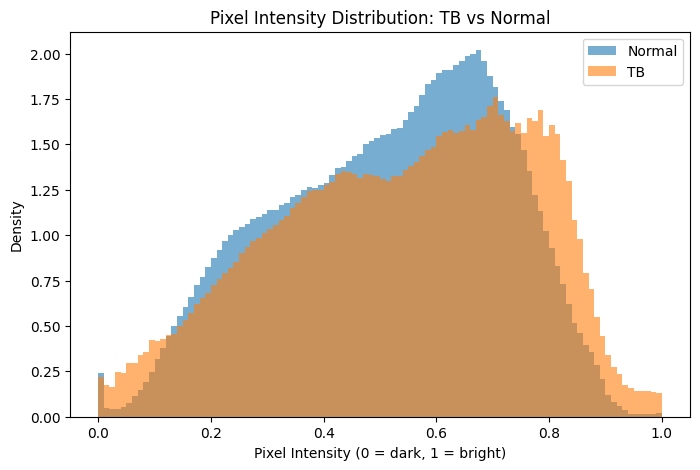

In [72]:
plt.figure(figsize=(8,5))

plt.hist(nor_pixels, bins=100, alpha=0.6, label="Normal", density=True)
plt.hist(tb_pixels, bins=100, alpha=0.6, label="TB", density=True)

plt.xlabel("Pixel Intensity (0 = dark, 1 = bright)")
plt.ylabel("Density")
plt.title("Pixel Intensity Distribution: TB vs Normal")
plt.legend()
plt.show()

### Model

In [76]:
#Handling class imbalance:
from sklearn.utils.class_weight import compute_class_weight

class_weight = compute_class_weight(
    class_weight= 'balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight = dict(enumerate(class_weight))
class_weight

{0: np.float64(2.923611111111111), 1: np.float64(0.6031518624641834)}

In [77]:
#Needed metrics:
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC

In [78]:
#prerequisites:
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras import layers, models

In [80]:
#Model training:
def build_model(base_model,lr=1e-4, dropout_rate=0.5 ):
    base_model.trainable =False
    model = keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    #for compiling:
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
        loss = 'binary_crossentropy',
        metrics = [
            Accuracy(name = 'accuracy'),
            Precision(name='precision'),
            Recall(name='recall'),
            AUC(name='roc_auc')
        ]
    )
    return model

In [81]:
#1 Resnet 50:
resnet_base = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

resnet_model = build_model(resnet_base)
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 266,497 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [89]:
#callbacks:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights = True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "resnet50_tb_best.keras",
        monitor = 'val_loss',
        save_best_only = True
    )
]

In [90]:
#training:
training_on_resnet = resnet_model.fit(
    train_ds, 
    validation_data = val_ds,
    epochs =30,
    class_weight = class_weight,
    callbacks = callbacks
)

Epoch 1/30


66/66 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.0019 - loss: 0.2191 - precision: 0.9820 - recall: 0.9033 - roc_auc: 0.9735 - val_accuracy: 0.0022 - val_loss: 0.1588 - val_precision: 1.0000 - val_recall: 0.9251 - val_roc_auc: 0.9945
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.0012 - loss: 0.2190 - precision: 0.9857 - recall: 0.9097 - roc_auc: 0.9705 - val_accuracy: 0.0022 - val_loss: 0.1647 - val_precision: 1.0000 - val_recall: 0.9198 - val_roc_auc: 0.9952
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 9.1692e-04 - loss: 0.2291 - precision: 0.9848 - recall: 0.9060 - roc_auc: 0.9679 - val_accuracy: 0.0022 - val_loss: 0.1649 - val_precision: 1.0000 - val_recall: 0.9198 - val_roc_auc: 0.9951
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.0024 - loss: 0.2076 - precision: 0.9834 - recall: 0.9032 - roc_auc: 0.9750 - val_accuracy: 0.0022 - val_loss: 0.1563 - val_precision: 1.0000 - val_recall: 0.9251 - val_roc_auc: 0.9953
Epoch 5/30
66/6

In [ ]:
#testing fine tuning:
#loading the prev trained set so that the model dont train from the first
model = tf.keras.models.load_model("best_resnet50_tb_best.keras")

model.trainable = True
for layers in model.layers[:-50]:
    layers.trainable = False

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss = 'binary_crossentropy',
              metrics = [
                  Accuracy(name = 'accuracy'),
                  Precision(name='precision'),
                  Recall(name='recall'),
                  AUC(name='roc_auc')
                  ]
              )

c:\Users\TEMP\Anaconda\envs\stat_viz\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [101]:
resnet_fine_tune = model.fit(
    train_ds, 
    validation_data = val_ds,
    epochs =10,
    class_weight = class_weight
)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.0023 - loss: 0.2218 - precision: 0.9764 - recall: 0.9276 - roc_auc: 0.9721 - val_accuracy: 0.0089 - val_loss: 0.1157 - val_precision: 1.0000 - val_recall: 0.9465 - val_roc_auc: 0.9979
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.0043 - loss: 0.2014 - precision: 0.9800 - recall: 0.9211 - roc_auc: 0.9745 - val_accuracy: 0.0089 - val_loss: 0.1163 - val_precision: 1.0000 - val_recall: 0.9439 - val_roc_auc: 0.9979
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.0056 - loss: 0.2041 - precision: 0.9857 - recall: 0.9145 - roc_auc: 0.9733 - val_accuracy: 0.0089 - val_loss: 0.1172 - val_precision: 1.0000 - val_recall: 0.9439 - val_roc_auc: 0.9979
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.0018 - loss: 0.1772 - precision: 0.9896 - recall: 0.9199 - roc_auc: 0.9796 - val_accuracy: 0.0089 - val_loss: 0.1171 - val_precision: 1.0000 - val_recall: 0.9439 - val_roc_auc: 0.9980
Epoch 5/

In [ ]:
#Model 2 - EfficientNetB0:
#defining the model
eff_base = EfficientNetB0(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

eff_model = build_model(eff_base)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [104]:
#training the model:
eff_training = eff_model.fit(
    train_ds, 
    validation_data = val_ds,
    epochs=20,
    class_weight = class_weight,
    callbacks = callbacks
)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 51s 632ms/step - accuracy: 0.0000e+00 - loss: 0.8889 - precision: 0.8254 - recall: 0.5502 - roc_auc: 0.4981 - val_accuracy: 0.0000e+00 - val_loss: 0.7652 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 609ms/step - accuracy: 0.0000e+00 - loss: 0.8307 - precision: 0.8316 - recall: 0.5129 - roc_auc: 0.5055 - val_accuracy: 0.0000e+00 - val_loss: 0.7480 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 613ms/step - accuracy: 0.0000e+00 - loss: 0.8067 - precision: 0.8358 - recall: 0.5465 - roc_auc: 0.5392 - val_accuracy: 0.0000e+00 - val_loss: 0.7459 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5726
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 622ms/step - accuracy: 0.0000e+00 - loss: 0.8160 - precision: 0.8280 - recall: 0.4838 - roc_auc: 0.4897 - val_accuracy: 0.0000e+00 - val_loss: 0.7233 - val_p